# Prediksi Kecepatan Angin Maksimum di Tanjungpinang Tahun 2022 dengan ARIMA

Notebook ini dibuat untuk proyek akhir Pembelajaran Mesin. Topik dari proyek ini adalah memprediksi kecepatan angin maksimum di Tanjungpinang tahun 2022 dengan model ARIMA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

## Fungsi Utilitas

In [2]:
# Referensi kode: https://phdinds-aim.github.io/time_series_handbook/01_AutoRegressiveIntegratedMovingAverage/01_AutoRegressiveIntegratedMovingAverage.html
def evaluasi_model_arima(dataset, paramater_arima, ratio_latih=0.8):
    '''
      Menghitung nilai MAPE dan prediksi model untuk evaluasi
      Arg:
        dataset (pandas.Series): Dataset untuk model
        paramater_arima (tuple): Paramater ARIMA(p, d, q)
        ratio_latih (float): Ratio latih dengan rentang 0 hingga 1
      Hasil:
        mape (float): Nilai MAPE dalam desimal
        prediksi (pandas.Series): Prediksi model
    '''
    batas_latih = int(ratio_latih * len(dataset))
    dataset_latih = dataset[:batas_latih]
    dataset_validasi = dataset[batas_latih:]

    prediksi = pd.Series([])
    riwayat = dataset_latih.copy()

    for t in range(len(dataset_validasi)):
        model = ARIMA(riwayat, order=paramater_arima)
        model_fit = model.fit()

        yhat = model_fit.forecast()
        #yhat = yhat + riwayat.values[-1]
        prediksi = pd.concat([prediksi, yhat])
        riwayat = pd.concat([riwayat, pd.Series([dataset_validasi.values[t]])],
                            ignore_index='True')

    mape = mean_absolute_percentage_error(dataset_validasi, prediksi)
    return mape, prediksi

In [ ]:
def t_hitung(paramater, n):
    '''
        Menghitung nilai T_hitung.
        Arg:
          paramater (float): Paramater yang diuji
          n (int): Panjang dataset
        Hasil:
          t (float)
    '''
    se = np.sqrt((1 - ( paramater * paramater)) / n)
    t = paramater / se
    return t

## Pengujian Model dengan Data Dummy

### Buka Dataset Dummy

In [3]:
# Membuat data dummy
data_dummy = pd.read_csv('https://raw.githubusercontent.com/shamankares/prediksi-kecepatan-angin-TPI-ARIMA/77da031a6a9165e0c41e837a76e176e58052ef54/kecepatan_angin_dummy.csv')
data_dummy.head()

,kecepatan_angin
0,7
1,8
2,14
3,5
4,14


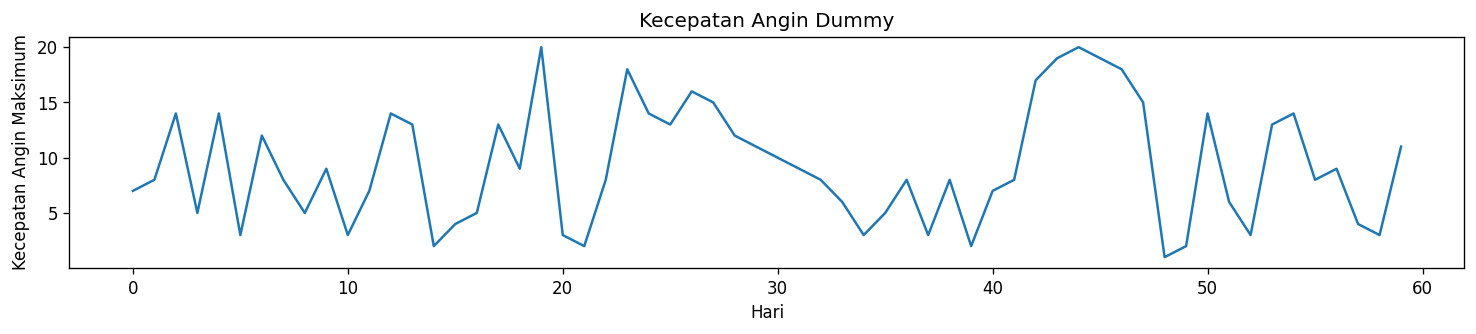

In [4]:
dummy_kec_angin = data_dummy['kecepatan_angin']

# Plot dataset dummy
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})
fig, ax = plt.subplots()
plt.plot(dummy_kec_angin)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Dummy')

plt.show()

### Uji Statisioner Data Dummy

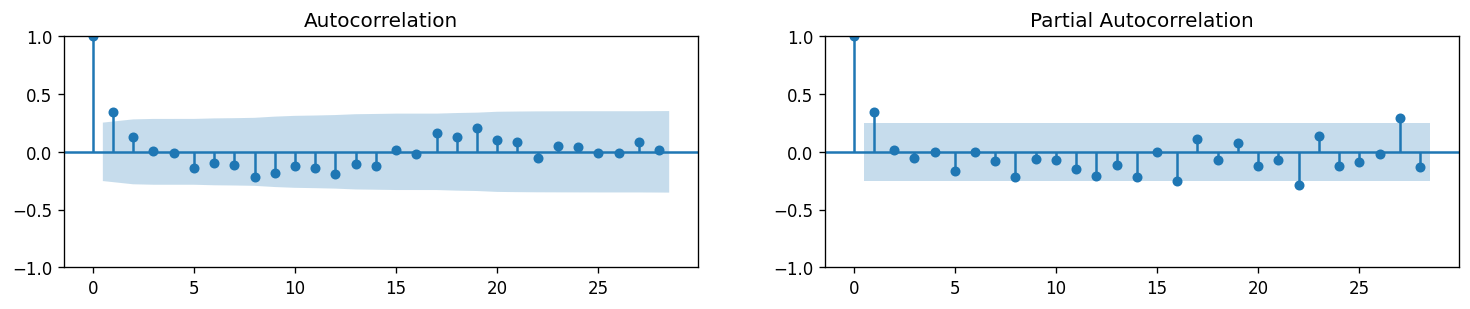

In [5]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

plot_acf(dummy_kec_angin, ax=axes[0], lags=28)
plot_pacf(dummy_kec_angin, ax=axes[1], lags=28)

plt.show()

In [6]:
acf_data_dummy = acf(dummy_kec_angin, nlags=28)
pacf_data_dummy = pacf(dummy_kec_angin, nlags=28)

print('\t ACF\t\t PACF')
for idx, (a, p) in enumerate(zip(acf_data_dummy, pacf_data_dummy)):
  print(f'{idx}\t {a:.6f}\t {p:.6f}')

	 ACF		 PACF
0	 1.000000	 1.000000
1	 0.341499	 0.347287
2	 0.132622	 0.018862
3	 0.008692	 -0.050221
4	 -0.006980	 0.002168
5	 -0.143158	 -0.168449
6	 -0.093046	 0.001138
7	 -0.117213	 -0.083523
8	 -0.220005	 -0.220336
9	 -0.180561	 -0.060608
10	 -0.120374	 -0.069072
11	 -0.140788	 -0.151559
12	 -0.190241	 -0.209934
13	 -0.106941	 -0.111456
14	 -0.118662	 -0.217495
15	 0.015211	 0.000574
16	 -0.021599	 -0.251748
17	 0.164428	 0.109899
18	 0.131173	 -0.070414
19	 0.203213	 0.075326
20	 0.104175	 -0.120055
21	 0.086132	 -0.068065
22	 -0.052417	 -0.289787
23	 0.051034	 0.134439
24	 0.039510	 -0.123862
25	 -0.011919	 -0.085281
26	 -0.007639	 -0.015357
27	 0.088503	 0.290514
28	 0.012380	 -0.134097


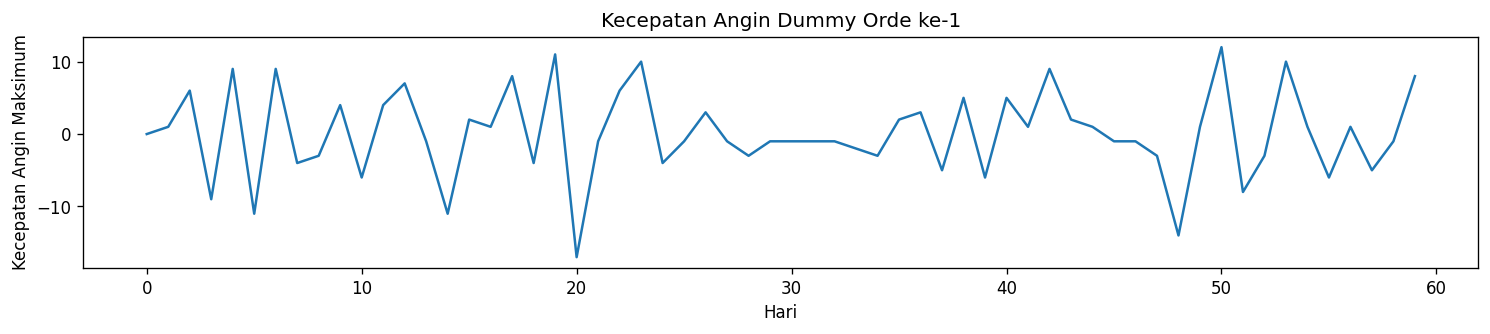

In [7]:
dummy_kec_angin_orde_1 = dummy_kec_angin.diff().fillna(0)

# Plot dataset dummy
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})
fig, ax = plt.subplots()
plt.plot(dummy_kec_angin_orde_1)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Dummy Orde ke-1')

plt.show()

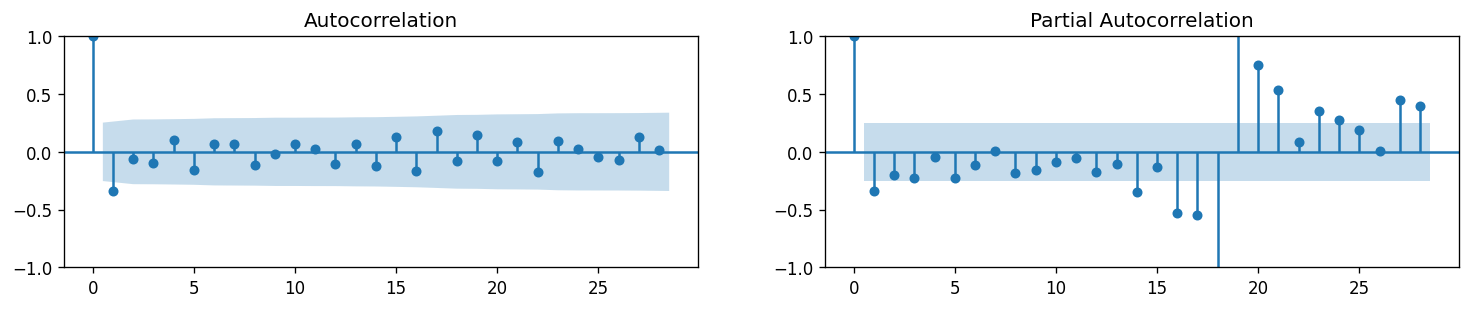

In [8]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

plot_acf(dummy_kec_angin_orde_1, ax=axes[0], lags=28)
plot_pacf(dummy_kec_angin_orde_1, ax=axes[1], lags=28)

plt.show()

In [9]:
acf_data_dummy = acf(dummy_kec_angin_orde_1, nlags=28)
pacf_data_dummy = pacf(dummy_kec_angin_orde_1, nlags=28)

print('\t ACF\t\t PACF')
for idx, (a, p) in enumerate(zip(acf_data_dummy, pacf_data_dummy)):
  print(f'{idx}\t {a:.6f}\t {p:.6f}')

	 ACF		 PACF
0	 1.000000	 1.000000
1	 -0.335514	 -0.341200
2	 -0.059060	 -0.200902
3	 -0.095621	 -0.229074
4	 0.101992	 -0.040785
5	 -0.158114	 -0.226394
6	 0.066542	 -0.113435
7	 0.063499	 0.009748
8	 -0.113791	 -0.185353
9	 -0.017906	 -0.157936
10	 0.064336	 -0.084427
11	 0.027142	 -0.054470
12	 -0.104614	 -0.176195
13	 0.068967	 -0.108447
14	 -0.123530	 -0.350941
15	 0.130880	 -0.134263
16	 -0.168526	 -0.530384
17	 0.176681	 -0.546981
18	 -0.077582	 -1.350870
19	 0.142767	 3.198146
20	 -0.075388	 0.750779
21	 0.086087	 0.531519
22	 -0.174440	 0.085960
23	 0.094364	 0.352079
24	 0.028802	 0.274822
25	 -0.041729	 0.188075
26	 -0.068955	 0.006930
27	 0.128929	 0.447201
28	 0.015935	 0.396724


### Mencari Paramater ARIMA Terbaik

In [42]:
# Model ARIMA (AR)(1)
ar_1_dummy = ARIMA(dummy_kec_angin, order=(1, 1, 0))
ar_1_dummy_fit = ar_1_dummy.fit(method="yule_walker")
ar_1_dummy_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        kecepatan_angin   No. Observations:                   60
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -187.080
Date:                Sat, 08 Jul 2023   AIC                            378.161
Time:                        13:57:47   BIC                            382.316
Sample:                             0   HQIC                           379.783
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3356      0.123     -2.724      0.006      -0.577      -0.094
sigma2        33.2992      6.086      5.471      0.000      21.370      45.228
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.55   Prob(JB):                         0.97
Heteroskedasticity (H):               0.98   Skew:                            -0.07
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# Model ARIMA (AR)(2)
ar_2_dummy = ARIMA(dummy_kec_angin, order=(2, 1, 0))
ar_2_dummy_fit = ar_2_dummy.fit(method="yule_walker")
ar_2_dummy_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        kecepatan_angin   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -185.884
Date:                Sat, 08 Jul 2023   AIC                            377.768
Time:                        13:57:55   BIC                            384.001
Sample:                             0   HQIC                           380.201
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4006      0.132     -3.029      0.002      -0.660      -0.141
ar.L2         -0.1936      0.137     -1.411      0.158      -0.463       0.075
sigma2        32.0512      5.747      5.577      0.000      20.787      43.316
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.67   Prob(JB):                         0.90
Heteroskedasticity (H):               0.88   Skew:                            -0.11
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# Model ARIMA (MA)(1)
ma_1_dummy = ARIMA(dummy_kec_angin, order=(0, 1, 1))
ma_1_dummy_fit = ma_1_dummy.fit()
ma_1_dummy_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        kecepatan_angin   No. Observations:                   60
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -184.499
Date:                Sat, 08 Jul 2023   AIC                            372.998
Time:                        13:57:30   BIC                            377.153
Sample:                             0   HQIC                           374.619
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6223      0.100     -6.241      0.000      -0.818      -0.427
sigma2        30.2052      5.788      5.219      0.000      18.861      41.549
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.37   Prob(JB):                         0.95
Heteroskedasticity (H):               1.23   Skew:                            -0.09
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Model ARIMA (ARMA)(1, 1)
arma_1_1_dummy = ARIMA(dummy_kec_angin, order=(1, 1, 1))
arma_1_1_dummy_fit = arma_1_1_dummy.fit()
arma_1_1_dummy_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        kecepatan_angin   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -180.654
Date:                Sat, 08 Jul 2023   AIC                            367.308
Time:                        13:55:32   BIC                            373.540
Sample:                             0   HQIC                           369.741
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3598      0.130      2.758      0.006       0.104       0.616
ma.L1         -0.9987      2.002     -0.499      0.618      -4.922       2.924
sigma2        25.2872     51.288      0.493      0.622     -75.236     125.811
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.86   Prob(JB):                         0.56
Heteroskedasticity (H):               0.96   Skew:                            -0.03
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
ar_1_dummy_fit.polynomial_ar

array([1.        , 0.33559169])

### Membagi Dataset Dummy

In [14]:
# Split dataset dummy
ratio_latih = 0.7
ukuran_latih = int(len(dummy_kec_angin) * ratio_latih)

dummy_latih = dummy_kec_angin[:ukuran_latih]
dummy_validasi = dummy_kec_angin[ukuran_latih:]

### Melatih Dataset Dummy

In [15]:
# Membuat model ARIMA dari dataset dummy
paramater_dummy = (2, 1, 0)
model = ARIMA(dummy_kec_angin, order=paramater_dummy)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        kecepatan_angin   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -185.880
Date:                Sat, 08 Jul 2023   AIC                            377.760
Time:                        13:21:25   BIC                            383.992
Sample:                             0   HQIC                           380.193
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4104      0.131     -3.140      0.002      -0.667      -0.154
ar.L2         -0.2013      0.137     -1.471      0.141      -0.470       0.067
sigma2        31.8049      5.659      5.621      0.000      20.714      42.896
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.71   Prob(JB):                         0.90
Heteroskedasticity (H):               0.88   Skew:                            -0.11
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

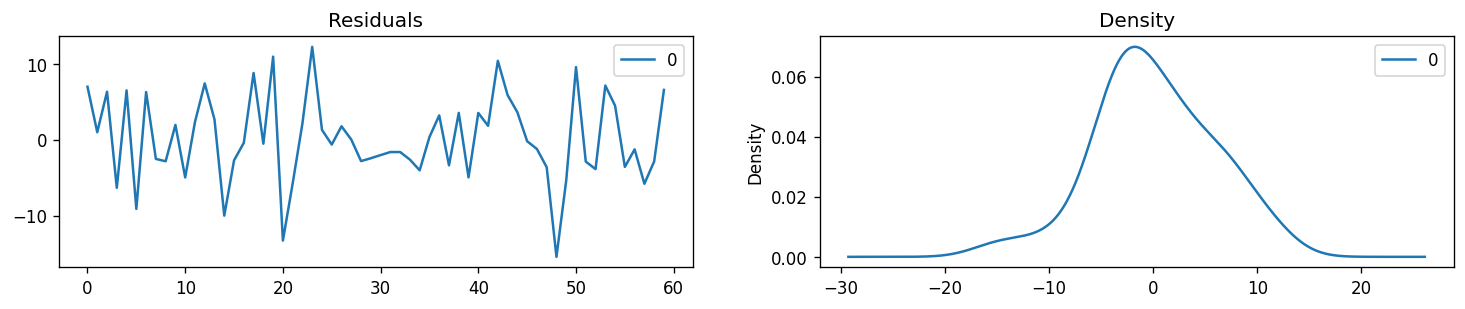

In [16]:
# Plot galat residual
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

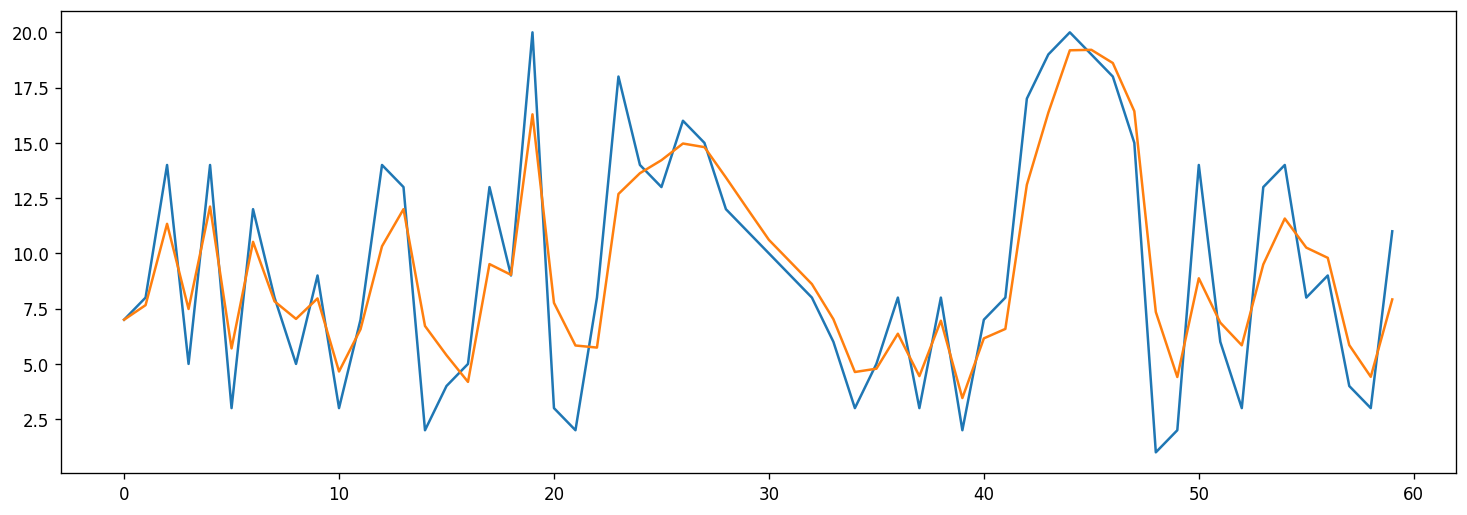

Nilai MAPE: 0.4266514905944173


In [17]:
# Plot prediksi dari dataset dummy latih
fig, ax = plt.subplots(figsize=(15,5))
ax = dummy_kec_angin.plot(ax=ax)
prediksi = model_fit.predict(end=len(dummy_kec_angin), dynamic=False).shift(-1).dropna()
prediksi.plot()
plt.show()
print(f'Nilai MAPE: {mean_absolute_percentage_error(dummy_kec_angin, prediksi)}')

### Validasi Model ARIMA

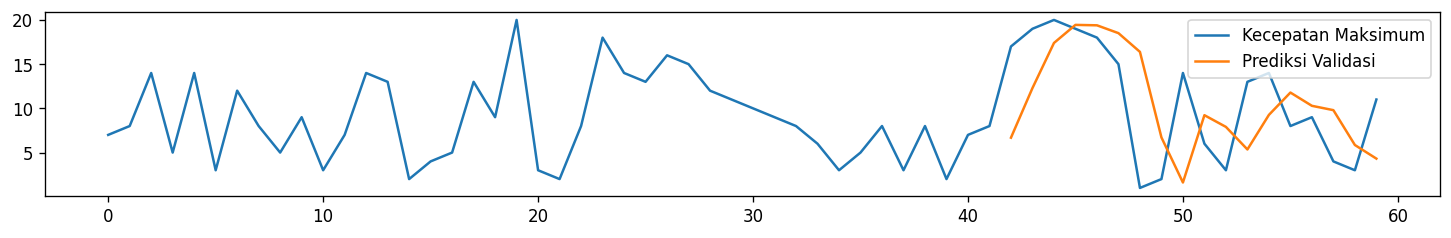

Nilai MAPE: 1.4875050741071616


In [18]:
# Plot evaluasi model ARIMA untuk dummy
mape, prediksi = evaluasi_model_arima(dummy_kec_angin, paramater_dummy, ratio_latih)

fig, ax = plt.subplots(figsize=(15,2))
dummy_kec_angin.plot(ax=ax, label="Kecepatan Maksimum")
prediksi.plot(ax=ax, label="Prediksi Validasi")
plt.legend()
plt.show()
print(f'Nilai MAPE: {mape}')

## Pengujian Model dengan Data Nyata

### Buka Dataset

In [19]:
# Buka dataset
df_kecepatan_angin = pd.read_csv('https://raw.githubusercontent.com/shamankares/prediksi-kecepatan-angin-TPI-ARIMA/main/kecepatan_angin_tpi_2022.csv',
                                 delimiter=';'
                                )
df_kecepatan_angin

,tanggal,kecepatan_maksimum
0,01/01/2022,4
1,02/01/2022,3
2,03/01/2022,3
3,04/01/2022,6
4,05/01/2022,7
...,...,...
361,28/12/2022,6
362,29/12/2022,8
363,30/12/2022,10
364,31/12/2022,13


In [20]:
df_kecepatan_angin['kecepatan_maksimum'].describe()

count    366.000000
mean       5.838798
std        1.854642
min        3.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       15.000000
Name: kecepatan_maksimum, dtype: float64

In [21]:
# Konversi tipe data kolom tanggal menjadi tipe data datetime
df_kecepatan_angin['tanggal'] = pd.to_datetime(df_kecepatan_angin['tanggal'], dayfirst=True)

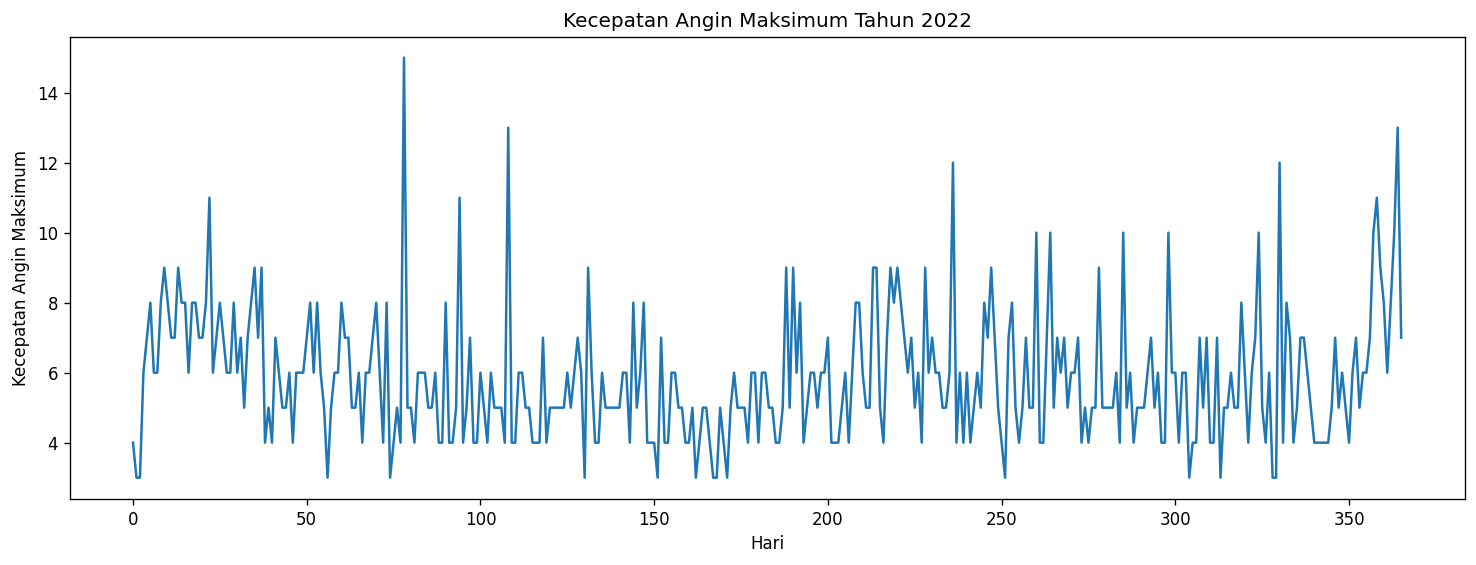

In [22]:
kecepatan_angin = df_kecepatan_angin['kecepatan_maksimum']

# Plot dataset
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(kecepatan_angin)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Maksimum Tahun 2022')

plt.show()

### Uji Statisioner Data

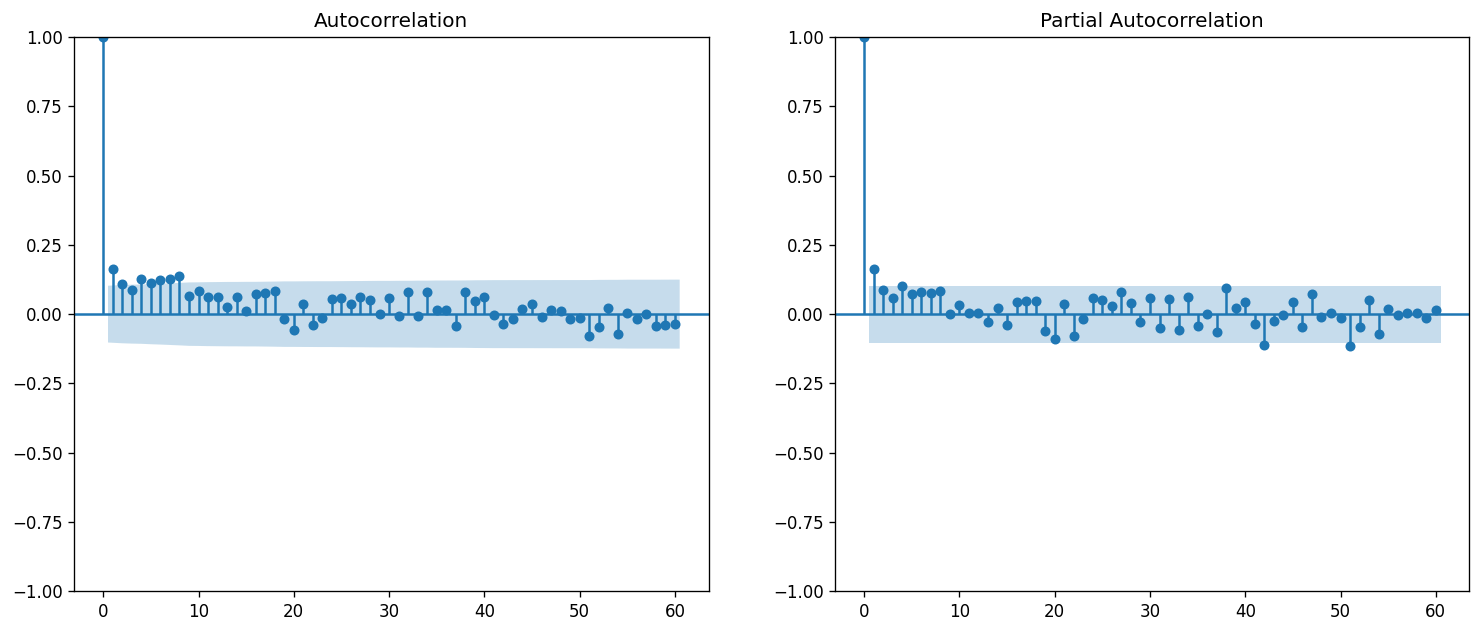

In [23]:
# Plot nilai ACF dan PACF dataset
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_acf(kecepatan_angin, ax=ax[0], lags=60)
plot_pacf(kecepatan_angin, ax=ax[1], lags=60)

plt.show()

In [24]:
acf_data_real = acf(kecepatan_angin, nlags=60)
pacf_data_real = pacf(kecepatan_angin, nlags=60)

print('\t ACF\t\t PACF')
for idx, (a, p) in enumerate(zip(acf_data_real, pacf_data_real)):
  print(f'{idx}\t {a:.6f}\t {p:.6f}')

	 ACF		 PACF
0	 1.000000	 1.000000
1	 0.162187	 0.162632
2	 0.109880	 0.086318
3	 0.085836	 0.058047
4	 0.126180	 0.100851
5	 0.111694	 0.071765
6	 0.123107	 0.080995
7	 0.125091	 0.077851
8	 0.136376	 0.083552
9	 0.065493	 -0.000045
10	 0.084074	 0.032073
11	 0.060698	 0.003275
12	 0.061346	 0.004659
13	 0.024686	 -0.029495
14	 0.062384	 0.020532
15	 0.009537	 -0.040189
16	 0.072440	 0.044893
17	 0.075734	 0.046755
18	 0.084218	 0.047771
19	 -0.018680	 -0.062609
20	 -0.057986	 -0.089868
21	 0.036777	 0.037710
22	 -0.040505	 -0.079493
23	 -0.013033	 -0.017837
24	 0.054109	 0.057116
25	 0.058996	 0.051043
26	 0.035877	 0.028731
27	 0.062141	 0.078936
28	 0.050172	 0.039904
29	 -0.000953	 -0.028926
30	 0.057582	 0.059438
31	 -0.006030	 -0.048476
32	 0.078507	 0.054993
33	 -0.005146	 -0.057695
34	 0.079673	 0.060625
35	 0.015136	 -0.043652
36	 0.016349	 0.001046
37	 -0.042356	 -0.065348
38	 0.081081	 0.093941
39	 0.047864	 0.022060
40	 0.060176	 0.042343
41	 -0.003179	 -0.034141
42	 -0.03

Berdasarkan grafik tersebut, karena data tersebut menunjukkan penurunan secara lamban, maka data kecepatan angin maksimum perlu di-_differencing_ (menghitung selisih antardata).

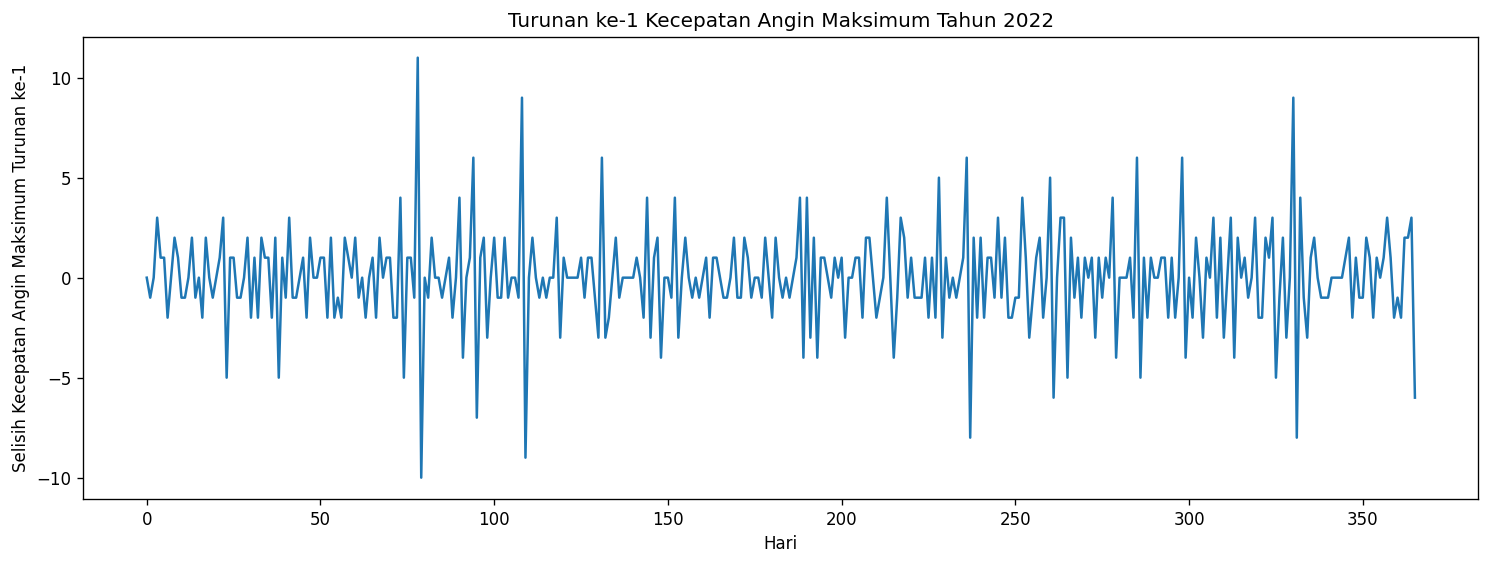

In [25]:
kecepatan_angin_orde_1 = kecepatan_angin.diff().fillna(0)

# Plot dataset turunan ke-1
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(kecepatan_angin_orde_1)

ax.set_xlabel('Hari')
ax.set_ylabel('Selisih Kecepatan Angin Maksimum Turunan ke-1')
ax.set_title('Turunan ke-1 Kecepatan Angin Maksimum Tahun 2022')

plt.show()

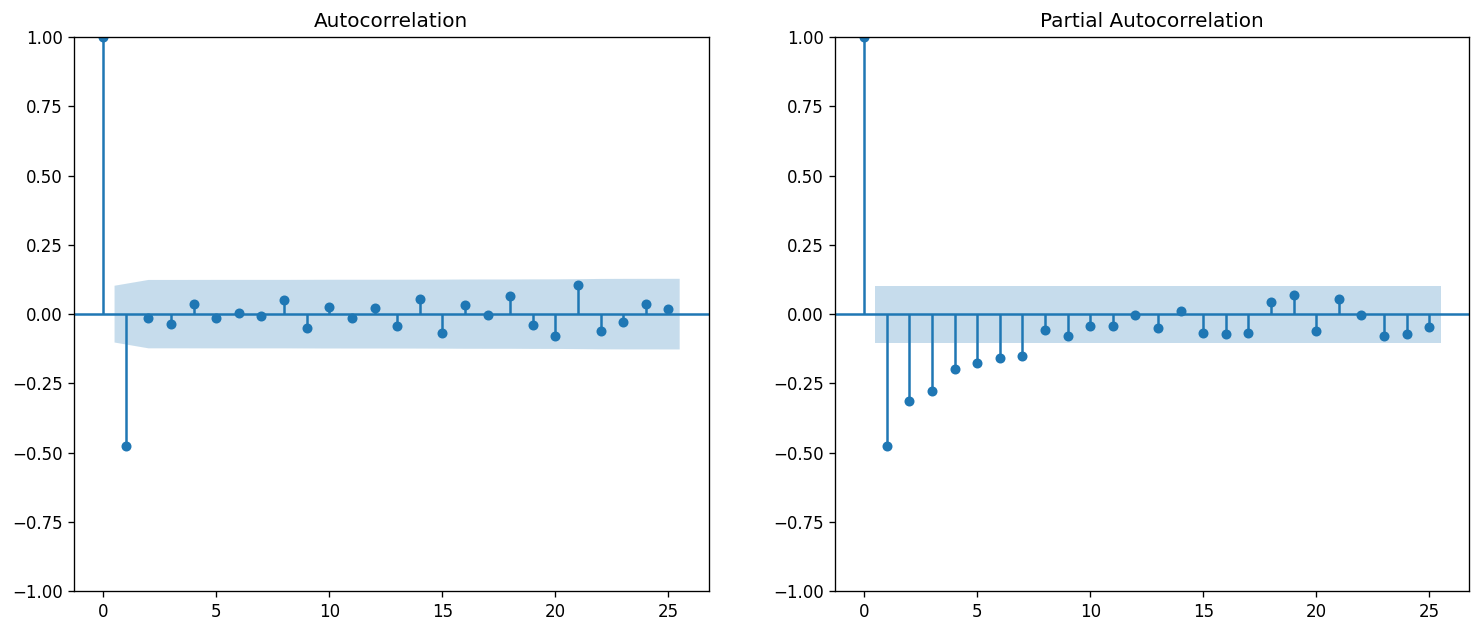

In [26]:
# Plot nilai ACF dan PACF dari turunan ke-1
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_acf(kecepatan_angin_orde_1, ax=ax[0], lags=25)
plot_pacf(kecepatan_angin_orde_1, ax=ax[1], lags=25)

plt.show()

### Mencari Paramater ARIMA Terbaik

In [45]:
# Menentukan paramater terbaik untuk dataset
daftar_paramater = [(1, 1, 0),
                    (2, 1, 0),
                    (0, 1, 1),
                    (1, 1, 1)]

mape_terendah = float('inf')
paramater_terbaik = None

for paramater in daftar_paramater:
    try:
        mape, _ = evaluasi_model_arima(kecepatan_angin, paramater)
        if mape < mape_terendah:
            mape_terendah = mape
            paramater_terbaik = paramater
        print(f'ARIMA{paramater} MAPE: {mape}')
    except:
        continue

print(f'Paramater terbaik: {paramater_terbaik}')

ARIMA(1, 1, 0) MAPE: 0.3002318174620226
ARIMA(2, 1, 0) MAPE: 0.2743858502835723
ARIMA(0, 1, 1) MAPE: 0.266387292989638
ARIMA(1, 1, 1) MAPE: 0.2668279388862392
Paramater terbaik: (0, 1, 1)


### Membagi Dataset

In [46]:
# Split dataset
ratio_latih = 0.7
ukuran_latih = int(len(kecepatan_angin) * ratio_latih)

dataset_latih = kecepatan_angin[:ukuran_latih]
dataset_validasi = kecepatan_angin[ukuran_latih:]

### Melatih Model ARIMA

In [47]:
model = ARIMA(dataset_latih, order=paramater_terbaik)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     kecepatan_maksimum   No. Observations:                  256
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -504.100
Date:                Sat, 08 Jul 2023   AIC                           1012.199
Time:                        14:49:52   BIC                           1019.282
Sample:                             0   HQIC                          1015.048
                                - 256                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9261      0.029    -32.007      0.000      -0.983      -0.869
sigma2         3.0289      0.180     16.850      0.000       2.677       3.381
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               265.83
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             1.37
Prob(H) (two-sided):                  0.50   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

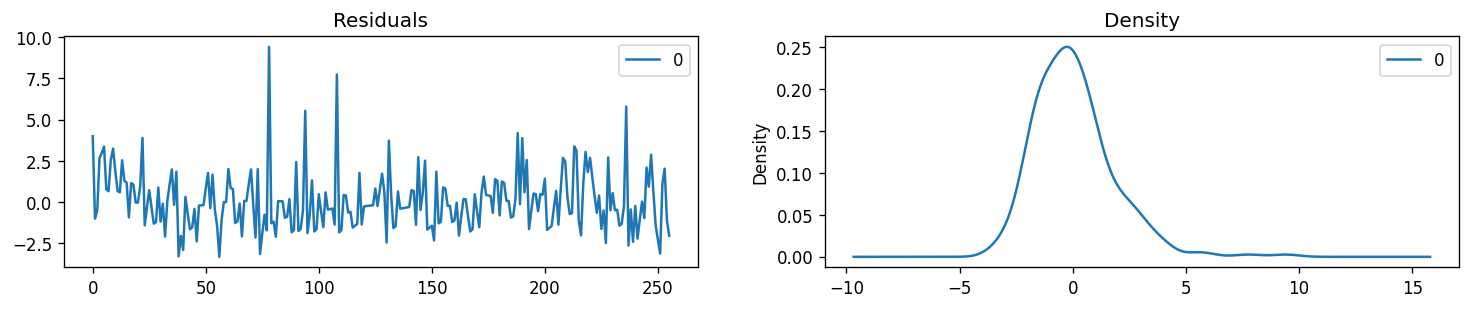

In [48]:
# Plot galat residual
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

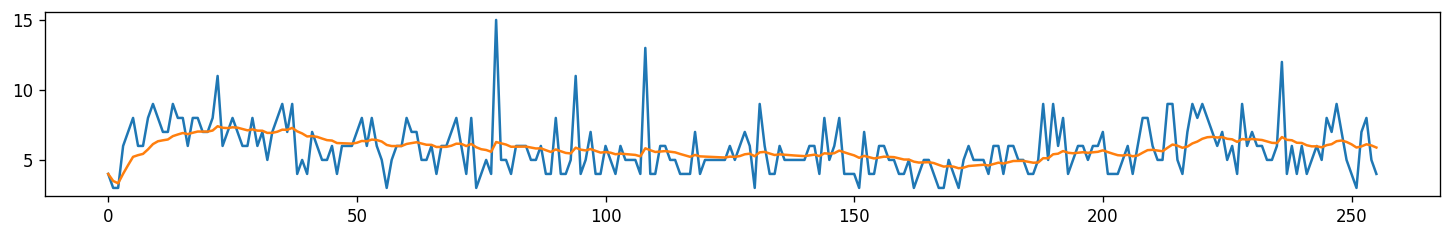

Nilai MAPE: 0.21410313492933347


In [49]:
# Plot prediksi dari dataset latih nyata
fig, ax = plt.subplots(figsize=(15,2))
ax = dataset_latih.plot(ax=ax)
prediksi = model_fit.predict(end=len(dataset_latih), dynamic=False).shift(-1).dropna()
prediksi.plot()
plt.show()
print(f'Nilai MAPE: {mean_absolute_percentage_error(dataset_latih, prediksi)}')

### Validasi Model ARIMA

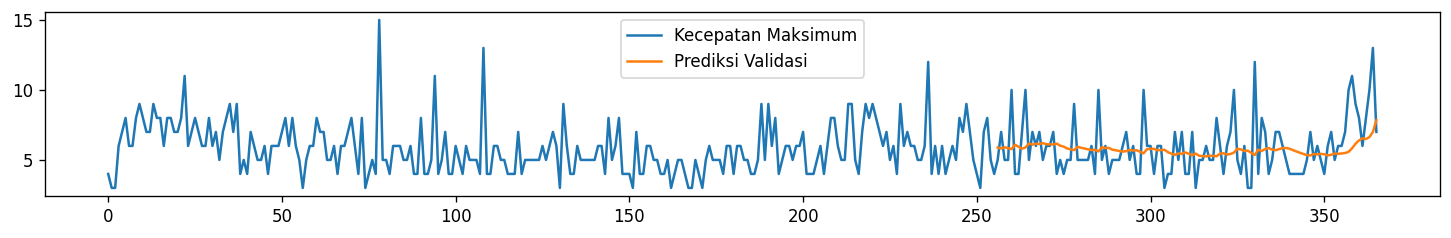

Nilai MAPE: 0.2539469349360332


In [50]:
mape, prediksi = evaluasi_model_arima(kecepatan_angin, paramater_terbaik, ratio_latih)

fig, ax = plt.subplots(figsize=(15,2))
kecepatan_angin.plot(ax=ax, label="Kecepatan Maksimum")
prediksi.plot(ax=ax, label="Prediksi Validasi")
plt.legend()
plt.show()
print(f'Nilai MAPE: {mape}')